In [39]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
import pandas_datareader as pdr
from tensorflow import keras
from tensorflow.keras.layers import Dense, LSTM, Dropout, Flatten
from tensorflow.keras import Sequential
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, cohen_kappa_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

First, lets fit a simple random forest classifier on historical S&P500 data. The training dataset consists of the S&P500 daily closing prices from 1927 to 2020. The length of each input sequence to the model is determined by `num_lags`: this is the size of the time window/number of previous closing prices used to predict/forecast the closing price on the following day.

The model uses the movements in closing prices from the past `num_lags` days to predict whether the price will go up or down in the next day in the sequence.

In [2]:
DATA_PATH = 'cli/data/SP500.csv'

In [6]:
# read the prices data into a pandas dataframe
df = pd.read_csv(DATA_PATH)
closing_prices = df['Close']

# take the difference between each closing value to make the series stationary
stationary_data = closing_prices.diff().dropna()
# flatten the data array
stationary_data = np.array(stationary_data).flatten()

# classify positive returns as 1 and negative returns as -1, i.e. market 'up' and market 'down'
# stationary_data = np.where(stationary_data > 0, 1, -1)

In [14]:
# preprocess the data for training
NUM_LAGS = 30
SPLIT = 0.8

def preprocess(df):
    x, y = [], []
    for i in range(len(df) - NUM_LAGS):
        x.append(df[i : i + NUM_LAGS])
        # classify positive returns as 1 and negative returns as -1
        # i.e. market 'up' and market 'down'
        y.append(1 if df[i + NUM_LAGS] > 0 else -1)
    
    return np.array(x), np.array(y)

x, y = preprocess(stationary_data)
# split data into train and test sets
split_index = int(SPLIT * len(x))
x_train, y_train = x[:split_index], y[:split_index]
x_test, y_test = x[split_index:], y[split_index:]

In [15]:
N_ESTIMATORS = 100
RFClassifier = RandomForestClassifier(n_estimators=N_ESTIMATORS, random_state=0)

In [16]:
# fit the classifier and evaluate on test set
RFClassifier.fit(x_train, y_train)
y_predicted = RFClassifier.predict(x_test)

def evaluate(labels, predicted):
    accuracy = accuracy_score(labels, predicted)
    kappa = cohen_kappa_score(labels, predicted)
    return accuracy, kappa

accuracy, score = evaluate(y_test, y_predicted)
print(f"Accuracy: {accuracy:.2f}")
print(f"Kappa: {score:.2f}")

Accuracy: 0.51
Kappa: 0.01


Now, lets train a simple LSTM on the same dataset for the same classification task and compare performance.

In [18]:
optimizer = 'adam'
loss = 'mse'
model = Sequential()
# model.add(LSTM(128,return_sequences=True))
model.add(LSTM(64)) # model.add(LSTM(64,return_sequences=False))
# model.add(Dense(25))
model.add(Dense(1))
model.compile(optimizer=optimizer, loss=loss)
        
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/25
2330/2330 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.9944 - val_loss: 1.0230
Epoch 2/25
2330/2330 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.9951 - val_loss: 1.0302
Epoch 3/25
2330/2330 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.9942 - val_loss: 1.0351
Epoch 4/25
2330/2330 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.9934 - val_loss: 1.0447
Epoch 5/25
2330/2330 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.9924 - val_loss: 1.0527
Epoch 6/25
2330/2330 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.9917 - val_loss: 1.0612
Epoch 7/25
2330/2330 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.9916 - val_loss: 1.0711
Epoch 8/25
2330/2330 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.9905 - val_loss: 1.0801
Epoch 9/25
2330/2330 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.9903 - val_loss: 1.0908
Epoch 10/25
2330/2330 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.9897 - val_loss: 1.1083
Epoch 11/25
2330/2330 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.9902 - val_loss: 1.1308
Epoch 12/25
2330/2330 ━━━━━━━━

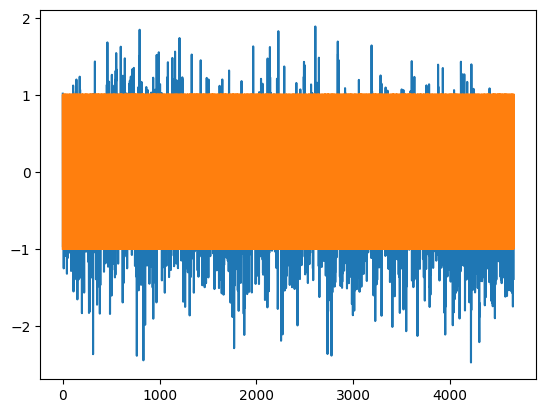

In [19]:
epochs = 25
batch_size = 8

# reshape input data: (batch, timesteps, feature)
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))
# do not shuffle data during training because order matters in time series
history = model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, 
                    validation_data=(x_test, y_test), shuffle=False)

In [25]:
# evaluate the model
y_predicted = [1 if pred > 0 else -1 for pred in model.predict(x_test)]

result_df = pd.DataFrame({'pred':list(np.reshape(y_predicted, (-1))),'act':list(np.reshape(y_test, (-1)))})
result_df.head()

146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


,pred,act
0,1,-1
1,-1,1
2,-1,-1
3,-1,-1
4,1,1


In [23]:
accuracy, score = evaluate(y_test, y_predicted)
print(f"Accuracy: {accuracy:.2f}")
print(f"Kappa: {score:.2f}")

Accuracy: 0.50
Kappa: 0.01


We will now train an LSTM for a regression task: forecast the next S&P500 closing price using the closing prices seen in the previous `num_lags` days.

In [44]:
df = pd.read_csv(DATA_PATH)
closing_prices = df['Close']

NUM_LAGS = 60

# normalize the input data
scaler = MinMaxScaler()
scaled_data = closing_prices.values.reshape(closing_prices.shape[0], 1)
scaled_data = scaler.fit_transform(scaled_data)

# preprocess data for training
def preprocess(df):
    x, y = [], []
    for i in range(len(df) - NUM_LAGS):
        x.append(df[i : i + NUM_LAGS, 0])
        y.append(df[i + NUM_LAGS, 0])

    return np.array(x), np.array(y)

x, y = preprocess(scaled_data)
# split data into train and test sets
split_index = int(SPLIT * len(x))
x_train, y_train = x[:split_index], y[:split_index]
x_test, y_test = x[split_index:], y[split_index:]

In [45]:
model = Sequential()
model.add(LSTM(64))
model.add(Dense(1))
model.compile(optimizer=optimizer, loss=loss)

In [46]:
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))

history = model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, 
                    validation_data=(x_test, y_test), shuffle=False)

Epoch 1/25
2327/2327 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - loss: 2.1494e-06 - val_loss: 0.0302
Epoch 2/25
2327/2327 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - loss: 4.1434e-04 - val_loss: 0.0190
Epoch 3/25
2327/2327 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - loss: 3.2955e-04 - val_loss: 0.0199
Epoch 4/25
2327/2327 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - loss: 3.8182e-04 - val_loss: 0.0199
Epoch 5/25
2327/2327 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - loss: 3.6391e-04 - val_loss: 0.0183
Epoch 6/25
2327/2327 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - loss: 3.4922e-04 - val_loss: 0.0163
Epoch 7/25
2327/2327 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - loss: 2.8755e-04 - val_loss: 0.0133
Epoch 8/25
2327/2327 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - loss: 2.5848e-04 - val_loss: 0.0126
Epoch 9/25
2327/2327 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - loss: 2.2073e-04 - val_loss: 0.0102
Epoch 10/25
2327/2327 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - loss: 1.8385e-04 - val_loss: 0.0084
Epoch 11/25
2327/2327 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - loss: 1.416

146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


,pred,act
0,1105.316895,1091.069946
1,1097.792358,1098.229980
2,1105.642212,1106.589966
3,1113.511841,1091.880005
4,1098.143921,1079.880005


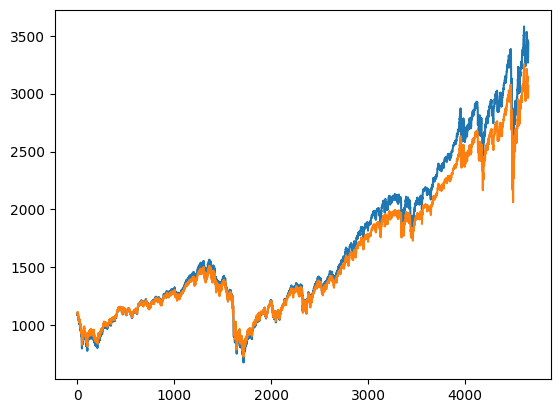

In [47]:
y_predicted = model.predict(x_test)
pred = scaler.inverse_transform(y_predicted)
actual = scaler.inverse_transform(y_test.reshape(-1,1))
plt.plot(actual)
plt.plot(pred)

result_df = pd.DataFrame({'pred':list(np.reshape(pred, (-1))),'act':list(np.reshape(actual, (-1)))})
result_df.head()

In [48]:
test = result_df['act']
forecast = result_df['pred']

print('LSTM model MSE :', mean_squared_error(test, forecast))
print('LSTM model MAE :', mean_absolute_error(test, forecast))
print('LSTM model MAPE :', mean_absolute_percentage_error(test, forecast))

LSTM model MSE : 15393.436559284713
LSTM model MAE : 85.80695145108079
LSTM model MAPE : 0.040661404659154576


In [56]:
actual = scaled_data[-1]
x = scaled_data[-NUM_LAGS - 1 : -1]
print(x.shape)
x = x.reshape((x.shape[1], x.shape[0], 1))
print(x.shape)
y_pred = model.predict(x)

y_pred = scaler.inverse_transform(y_pred)
actual = scaler.inverse_transform(actual.reshape(-1,1))

print(actual, y_pred)

(60, 1)
(1, 60, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
[[3443.439941]] [[3065.5984]]
